In [306]:
from DeviceFingerprint.models import *

In [307]:
from Analyze.model import *
from Analyze.packet_converter import *

In [308]:
devices = Device.objects.all()

In [309]:
dlink1_mac = "b0:c5:54:25:1f:b6"
dlink2_mac = "c4:12:f5:1c:8c:f1"
dlink3_mac = "b0:c5:54:25:22:64"
unknown = "74:da:38:4a:a9:75"
edimax1_mac = "80:1f:02:d6:d5:5d"
edimax2_mac = "80:1f:02:d6:d5:59"
xiaomi_mac = "78:11:dc:11:72:af"

In [310]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [311]:
devices

<QuerySet [<Device: Device object (28)>, <Device: Device object (33)>, <Device: Device object (30)>, <Device: Device object (32)>, <Device: Device object (34)>, <Device: Device object (31)>, <Device: Device object (29)>]>

In [516]:
dlink3 = Device.objects.get(device_mac_address = dlink3_mac)

In [517]:
dlink3_packet_set = dlink3.packet_set.order_by('pk')

In [518]:
dlink3_packets = [ decode_packet(k.packet) for k in dlink3_packet_set ]

In [519]:
dlink3_tcp_packets = [ pkt for pkt in dlink3_packets if TCP in pkt ]

In [520]:
dlink3_packet_symbols = get_packet_symbols(dlink3_tcp_packets,dlink3_mac)

In [521]:
dlink3_train_data = torch.tensor(dlink3_packet_symbols[:300]).reshape(-1,20,1)

In [522]:
dlink3_test_data = torch.tensor(dlink3_packet_symbols[300:340]).reshape(-1,20,1)

In [523]:
dlink3_tcp_packets = [ pkt for pkt in dlink3_packet_set if TCP in decode_packet(pkt.packet)]

In [365]:
len(dlink3_tcp_packets)

349

In [349]:
len(dlink3_packet_symbols)

348

In [350]:
dlink2 = Device.objects.get(device_mac_address = dlink2_mac)
dlink2_packet_set = dlink2.packet_set.order_by('pk')
dlink2_packets = [ decode_packet(k.packet) for k in dlink2_packet_set ]
dlink2_tcp_packets = [ pkt for pkt in dlink2_packets if TCP in pkt ]
dlink2_packet_symbols = get_packet_symbols(dlink2_tcp_packets,dlink2_mac)
dlink2_train_data = torch.tensor(dlink2_packet_symbols[:300]).reshape(-1,20,1)
dlink2_test_data = torch.tensor(dlink2_packet_symbols[300:340]).reshape(-1,20,1)

In [351]:
pks = [ pkt.pk for pkt in dlink3_packet_set]

In [352]:
detection_sequence = list(dlink3.packet_set.order_by('pk'))

In [353]:
untrained_sequence =[ pkt for pkt in detection_sequence if pkt.pk > dlink3.anomaly_hwm]

In [354]:
detection_sequence[-1]

<PacketData: PacketData object (1244772)>

In [355]:
dlink3.anomaly_hwm

1244772

In [356]:
dlink3.anomaly_hwm = -1

In [357]:
dlink3.save()

In [57]:
model = RecurrentAutoencoder(20,1)

In [52]:
def train_model(model, train_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    print(epoch)
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    train_loss = np.mean(train_losses)
    print(train_loss)


In [53]:
def predict(model, dataset):

  predictions, losses = [], []

  criterion = nn.L1Loss(reduction='sum').to(device)

  with torch.no_grad():

    model = model.eval()

    for seq_true in dataset:

      seq_true = seq_true.to(device)

      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())

      losses.append(loss.item())

  return predictions, losses

In [170]:
train_model(model, dlink3_train_data,100)

1
0.2442099587784873
2
0.28084999836153457
3
0.23274104926321243
4
0.24234756661785972
5
0.23623684893051783
6
0.23388461702399785
7
0.29128261158863705
8
0.23699806216690275
9
0.23925800273815792
10
0.23825801942083571
11
0.2217237808638149
12
0.22439529283179177
13
0.2388036244445377
14
0.23254472331868278
15
0.22627176857656903
16
0.23079415178961224
17
0.22419886373811299
18
0.3549356965555085
19
0.2941434904932976
20
0.37414683600266774
21
1.1700970833500226
22
2.954317354824808
23
2.0203872346215777
24
2.0836590834789805
25
2.016729175713327
26
1.8348855088154474
27
1.653999646173583
28
1.4492396344741185
29
1.3212710597448878
30
1.2625003173947333
31
1.3719635902179612
32
1.0446165548430548
33
0.7782498907711771
34
0.6725060653355387
35
0.6281379726197984
36
0.5964048594236374
37
0.5727195999688572
38
0.5320513866013951
39
0.48821244256363977
40
0.46423853056298364
41
0.4460259185896979
42
0.4494493164949947
43
0.4573942351672384
44
0.45568706575367185
45
0.44967413809564377
46


In [126]:
dlink3_test_data.size()

torch.Size([12, 20, 1])

In [127]:
dlink2_test_data.size()

torch.Size([12, 20, 1])

In [85]:
predict(model, dlink3_test_data)

([array([-5.1259249e-03,  2.7017822e+00, -8.7176114e-03,  8.0266418e+00,
          2.3925543e+00,  7.9988986e-03,  1.1272582e+00, -1.5642045e-01,
          1.2643479e+00,  9.4337827e-01,  1.5708635e+00,  1.3021946e-02,
          6.8435061e-01,  5.8327818e-01,  1.0025035e+00,  7.7281151e+00,
          2.3527765e+00,  2.7804777e-02, -1.3970345e-02,  1.0110432e+00],
        dtype=float32),
  array([ 4.2960644e-02,  9.4987965e-01,  1.6010699e+00, -3.1150132e-03,
          1.0216765e+00,  2.9028907e-02,  1.8780756e+00,  8.0304146e+00,
          2.4511054e+00, -3.9871186e-03,  5.9120670e-02,  1.9550061e+00,
         -7.4782476e-02,  9.3222570e-01,  1.6088129e+00, -5.7449490e-03,
          4.2408794e-02,  1.9760275e+00, -2.8662428e-02,  8.0047798e+00],
        dtype=float32),
  array([ 2.4031446e+00,  2.5918633e-03, -1.7481342e-02,  1.8568218e+00,
          4.6122745e-02,  1.0053213e+00,  1.5889165e+00, -1.9419640e-03,
          1.0033319e+00, -5.1130190e-02,  1.8939526e+00,  7.9958606e+00,
 

In [13]:
files = os.listdir("./captures")

In [14]:
pcap_packets = rdpcap("./captures/20200411capture01.pcapng")

In [15]:
pcap_packets

<20200411capture01.pcapng: TCP:10851 UDP:6516 ICMP:9 Other:577>

In [16]:
pcap_packets[0].dst

'30:3a:64:8e:b1:65'

In [289]:
dlink1_packets = pcap_packets.filter(lambda x:x.src == dlink1_mac or x.dst==dlink1_mac )

In [290]:
dlink1_tcp_packets = [ pkt for pkt in dlink1_packets if TCP in pkt ]

In [291]:
dlink1_tcp_packet_symbols = get_packet_symbols(dlink1_tcp_packets, dlink1_mac)

In [292]:
dlink1_tcp_packet_symbols_tt = torch.tensor(dlink1_tcp_packet_symbols)

In [293]:
train_dataset = dlink1_tcp_packet_symbols_tt[:600].reshape(-1,20,1)

In [294]:
test_dataset = dlink1_tcp_packet_symbols_tt[600:900].reshape(-1,20,1)

In [295]:
y1 = np.array(c0_list[:X_length]).reshape(1,X_length)

In [296]:
dlink2_packets = pcap_packets.filter(lambda x:x.src == dlink2_mac or x.dst==dlink2_mac )
dlink2_tcp_packets = [ pkt for pkt in dlink2_packets if TCP in pkt ]
dlink2_tcp_packet_symbols = get_packet_symbols(dlink2_tcp_packets, dlink2_mac)

In [302]:
dlink1_tcp_packet_symbols

[[0, 1, 0, 0, 0.2, 0],
 [1, 0, 1, 0, 1.8, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 1, 0, 2, 2.4, 0],
 [1, 0, 1, 1, 1.6, 0],
 [1, 0, 1, 3, 1.6, 0],
 [1, 0, 1, 3, 1.6, 0],
 [1, 0, 1, 3, 1.6, 0],
 [1, 0, 1, 4, 2.4, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 1, 0, 5, 2.4, 0],
 [1, 0, 1, 6, 2.4, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 1, 0, 7, 2.4, 0],
 [1, 0, 1, 7, 2.4, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 1, 0, 8, 2.4, 0],
 [1, 0, 1, 1, 1.6, 0],
 [1, 0, 1, 8, 2.4, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 1, 0, 1, 1.7, 0],
 [1, 0, 1, 1, 1.7, 0],
 [0, 1, 0, 1, 1.6, 0],
 [0, 2, 0, 0, 0.2, 0],
 [1, 0, 2, 0, 1.8, 0],
 [0, 2, 0, 1, 1.6, 0],
 [0, 2, 0, 2, 2.4, 0],
 [1, 0, 2, 1, 1.6, 0],
 [1, 0, 2, 3, 1.6, 0],
 [1, 0, 2, 3, 1.6, 0],
 [1, 0, 2, 8, 2.4, 0],
 [0, 2, 0, 1, 1.6, 0],
 [0, 2, 0, 1, 1.6, 0],
 [0, 2, 0, 1, 1.6, 0],
 [1, 0, 2, 8, 2.4, 0],
 [0, 2, 0, 1, 1.6, 0],
 [0, 2, 0, 5, 2.4, 0],
 [1, 0, 2, 6, 2.4, 0],
 [0, 2, 0, 1, 1.6, 0],
 [0, 2, 0, 7, 2.4, 0],
 [1, 0, 2, 

In [298]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 5,2



In [301]:
dlink2_tcp_packet_symbols

[[0, 1, 0, 0, 0.2, 0],
 [1, 0, 1, 1, 1.8, 0],
 [0, 1, 0, 2, 1.6, 0],
 [0, 1, 0, 3, 2.4, 0],
 [1, 0, 1, 4, 1.6, 0],
 [1, 0, 1, 5, 1.6, 0],
 [1, 0, 1, 5, 1.6, 0],
 [1, 0, 1, 6, 2.4, 0],
 [1, 0, 1, 7, 2.4, 0],
 [0, 1, 0, 2, 1.6, 0],
 [0, 1, 0, 2, 1.6, 0],
 [0, 1, 0, 2, 1.6, 0],
 [0, 1, 0, 2, 1.6, 0],
 [0, 1, 0, 8, 2.4, 0],
 [1, 0, 1, 8, 2.4, 0],
 [0, 1, 0, 2, 1.6, 0],
 [0, 1, 0, 8, 2.4, 0],
 [1, 0, 1, 8, 2.4, 0],
 [1, 0, 1, 8, 2.4, 0],
 [0, 1, 0, 2, 2.0, 0],
 [0, 1, 0, 0, 0.2, 0],
 [1, 0, 1, 1, 1.8, 0],
 [0, 1, 0, 2, 1.6, 0],
 [0, 1, 0, 8, 2.4, 0],
 [1, 0, 1, 4, 1.6, 0],
 [1, 0, 1, 8, 2.4, 0],
 [0, 1, 0, 2, 1.6, 0],
 [0, 1, 0, 8, 2.4, 0],
 [1, 0, 1, 4, 1.6, 0],
 [0, 1, 0, 8, 2.4, 0],
 [1, 0, 1, 4, 1.6, 0],
 [1, 0, 1, 8, 2.4, 0],
 [1, 0, 1, 8, 2.4, 0],
 [0, 2, 0, 0, 0.2, 0],
 [0, 1, 0, 2, 2.0, 0],
 [1, 0, 2, 4, 1.8, 0],
 [0, 2, 0, 8, 1.6, 0],
 [0, 2, 0, 8, 2.4, 0],
 [1, 0, 2, 8, 1.6, 0],
 [1, 0, 2, 8, 2.4, 0],
 [1, 0, 2, 5, 1.6, 0],
 [1, 0, 2, 5, 1.6, 0],
 [1, 0, 2, 5, 1.6, 0],
 [1, 0, 2, 

In [300]:
c0_list = [ c[0] for c in dlink1_tcp_packet_symbols ]
c1_list = [ c[1] for c in dlink1_tcp_packet_symbols ]
c2_list = [ c[2] for c in dlink1_tcp_packet_symbols ]
c3_list = [ c[3] for c in dlink1_tcp_packet_symbols ]
c4_list = [ c[4] for c in dlink1_tcp_packet_symbols ]
c5_list = [ c[5] for c in dlink1_tcp_packet_symbols ]
c6_list = [0]*200 + [1]*100


X_start= 100;
X_end = 300;
X_length = X_end-X_start

y1 = np.array(c0_list[X_start:X_end]).reshape(1,X_length)
y2 = np.array(c1_list[X_start:X_end]).reshape(1,X_length)
y3 = np.array(c2_list[X_start:X_end]).reshape(1,X_length)
y4 = np.array(c3_list[X_start:X_end]).reshape(1,X_length)
y5 = np.array(c4_list[X_start:X_end]).reshape(1,X_length)
y6 = np.array(c6_list[X_start:X_end]).reshape(1,X_length)


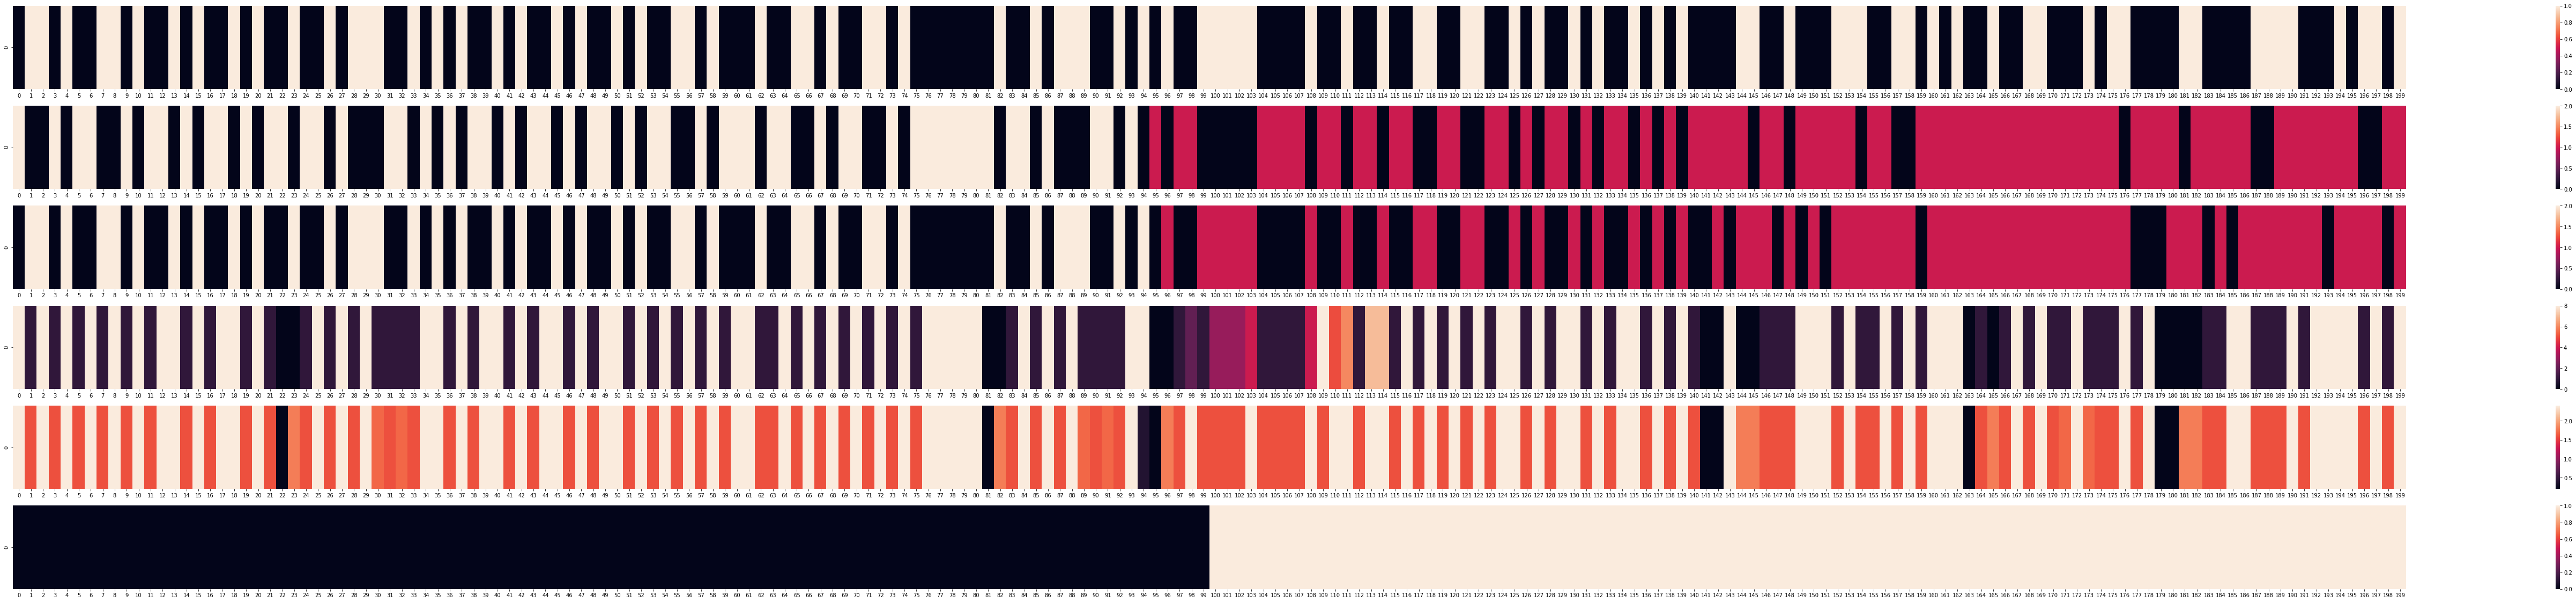

In [270]:
fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1, figsize=(100,20))
sns.heatmap(y1,ax=ax1)
sns.heatmap(y2,ax=ax2)
sns.heatmap(y3,ax=ax3)
sns.heatmap(y4,ax=ax4)
sns.heatmap(y5,ax=ax5)
sns.heatmap(y6,ax=ax6)
plt.show()

In [303]:
c0_list = [ c[0] for c in dlink2_tcp_packet_symbols ]
c1_list = [ c[1] for c in dlink2_tcp_packet_symbols ]
c2_list = [ c[2] for c in dlink2_tcp_packet_symbols ]
c3_list = [ c[3] for c in dlink2_tcp_packet_symbols ]
c4_list = [ c[4] for c in dlink2_tcp_packet_symbols ]
c5_list = [ c[5] for c in dlink2_tcp_packet_symbols ]
c6_list = [0]*200 + [1]*100


X_start= 100;
X_end = 300;
X_length = X_end-X_start

y1 = np.array(c0_list[X_start:X_end]).reshape(1,X_length)
y2 = np.array(c1_list[X_start:X_end]).reshape(1,X_length)
y3 = np.array(c2_list[X_start:X_end]).reshape(1,X_length)
y4 = np.array(c3_list[X_start:X_end]).reshape(1,X_length)
y5 = np.array(c4_list[X_start:X_end]).reshape(1,X_length)
y6 = np.array(c6_list[X_start:X_end]).reshape(1,X_length)

In [305]:
fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1, figsize=(100,20))
sns.heatmap(y1,ax=ax1)
sns.heatmap(y2,ax=ax2)
sns.heatmap(y3,ax=ax3)
sns.heatmap(y4,ax=ax4)
sns.heatmap(y5,ax=ax5)
sns.heatmap(y6,ax=ax6)
plt.show()

SyntaxError: invalid syntax (<ipython-input-305-269468c3bf4e>, line 2)

In [731]:
dlink3_packet_set = dlink3.packet_set.order_by('pk')

In [732]:
dlink3_tcp_packets = [ pkt for pkt in dlink3_packet_set if TCP in decode_packet(pkt.packet)]

In [733]:
tcp_packets_count = len(dlink3_tcp_packets)

In [734]:
tcp_packets_count

349

In [735]:
train_packets_count = math.floor(tcp_packets_count/20) * 20

In [736]:
train_packets_count

340

In [737]:
test_packets_count = math.floor(tcp_packets_count/20) * 20

In [738]:
test_packets_count

340

In [739]:
test_packets_objects = dlink3_tcp_packets[0:test_packets_count]

In [740]:
len(test_packets_objects)

340

In [741]:
PATH = "/home/ksign/Anomaly/anomaly/torch_models/b0c554252264model"

In [742]:
loaded_model = torch.load(PATH)

In [743]:
test_packets = [ decode_packet(pkt.packet) for pkt in test_packets_objects ]

In [744]:
len(test_packets)

340

In [745]:
packet_symbols = get_packet_symbols(test_packets,dlink3_mac)

In [746]:
index = 0

In [747]:
steps = math.floor(len(packet_symbols)/20)

In [748]:
len(packet_symbols)

339

In [749]:
L = []
for k in range(0,steps):
    low = 20 *k
    high = 20 *(k+1)
    L.append(packet_symbols[low:high])

In [750]:
len(L[-1])

20

In [751]:
all_losses = []

In [752]:
for l in L:
    input_symbols = torch.tensor(l).reshape(-1,20,1)
    pred,losses = predict(loaded_model,input_symbols)
    mean_loss = np.mean(losses)
    index= index+1
    all_losses.append(mean_loss)

In [753]:
all_losses

[0.5479065552353859,
 0.19092435389757156,
 0.6176923339565595,
 0.7677084431052208,
 1.0824144408106804,
 1.2321890120704968,
 1.2705461233854294,
 0.2322033792734146,
 0.2555552124977112,
 0.3021440679828326,
 0.24047350138425827,
 0.21386816104253134,
 0.3478138893842697,
 0.4976662223537763,
 0.1615580345193545,
 0.14383860677480698]

In [756]:
display_symbols = []
index = 0
for mean_loss in all_losses:
    low = 20* index
    high = 20*(index+1)
    if mean_loss > 5:
        for sequence in packet_symbols[low:high]:
            print(sequence)
            display_symbols.append(sequence+[0])
    else:
        for sequence in packet_symbols[low:high]:
            print(sequence)
            display_symbols.append(sequence+[1])
    

[0, 1, 0, 0, 0.2, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 2, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 3, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 4, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 5, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 6, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.7, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 2, 0, 0, 0.2, 0]
[0, 2, 0, 1, 1.6, 0]
[0, 2, 0, 2, 2.4, 0]
[0, 1, 0, 0, 0.2, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 2, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 3, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 4, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 5, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 6, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.7, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 2, 0, 0, 0.2, 0]
[0, 2, 0, 1, 1.6, 0]
[0, 2, 0, 2, 2.4, 0]
[0, 1, 0, 0, 0.2, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 2, 2.4, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 1, 1.6, 0]
[0, 1, 0, 3, 

In [757]:
display_symbols

[[0, 1, 0, 0, 0.2, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 2, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 3, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 4, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 5, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 6, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 1, 1.7, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 2, 0, 0, 0.2, 0, 1],
 [0, 2, 0, 1, 1.6, 0, 1],
 [0, 2, 0, 2, 2.4, 0, 1],
 [0, 1, 0, 0, 0.2, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 2, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 3, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 4, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 5, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 6, 2.4, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 1, 0, 1, 1.7, 0, 1],
 [0, 1, 0, 1, 1.6, 0, 1],
 [0, 2, 0, 0, 0.2, 0, 1],
 [0, 2, 0, 1

In [759]:
for symbol in display_symbols:
    print(symbol)

[0, 1, 0, 0, 0.2, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 2, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 3, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 4, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 5, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 6, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 1, 1.7, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 2, 0, 0, 0.2, 0, 1]
[0, 2, 0, 1, 1.6, 0, 1]
[0, 2, 0, 2, 2.4, 0, 1]
[0, 1, 0, 0, 0.2, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 2, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 3, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 4, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 5, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 6, 2.4, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 1, 0, 1, 1.7, 0, 1]
[0, 1, 0, 1, 1.6, 0, 1]
[0, 2, 0, 0, 0.2, 0, 1]
[0, 2, 0, 1, 1.6, 0, 1]
[0, 2, 0, 2, 2.4, 0, 1]
[0, 1, 0, 0, 0.2, 0, 1]
[0, 1, 0, 1, 1.6